Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/drive/')
#navigate to directory containing dataset
%cd /content/drive/My Drive/Colab Notebooks/Data/SkinCancer/
##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Colab Notebooks/Data/SkinCancer


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Train")
data_dir_test = pathlib.Path('Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='training',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='validation',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

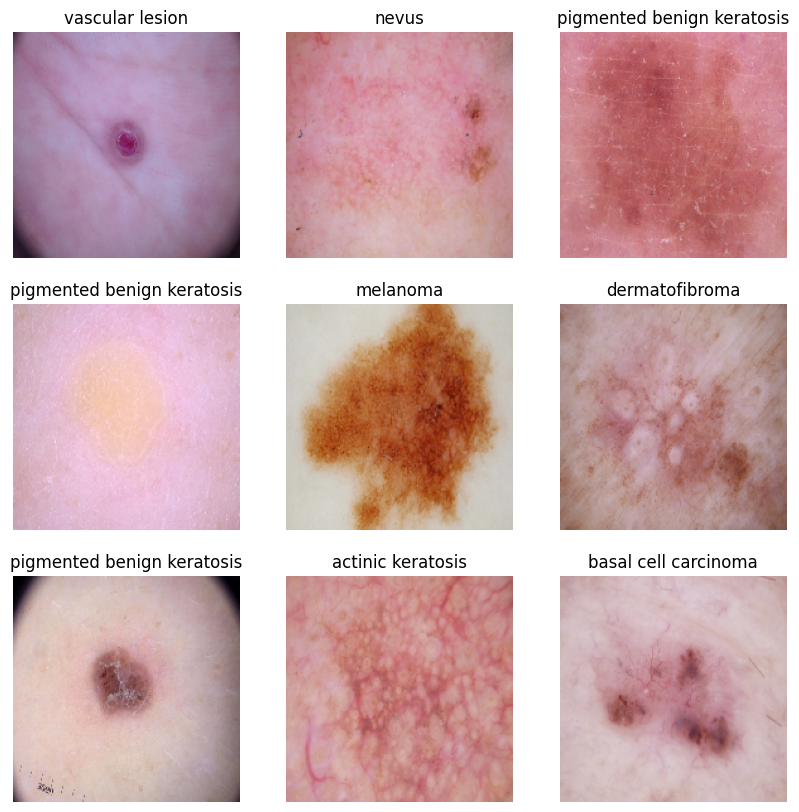

In [9]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
### Your code goes here
from tensorflow.keras import layers, models
import tensorflow as tf

model = models.Sequential([
    # Rescaling the input images
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation=tf.nn.relu),
    layers.Dense(9, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [12]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 53s 226ms/step - accuracy: 0.2208 - loss: 2.1312 - val_accuracy: 0.3400 - val_loss: 1.8495
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3282 - loss: 1.7901 - val_accuracy: 0.5011 - val_loss: 1.5328
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4724 - loss: 1.5242 - val_accuracy: 0.5056 - val_loss: 1.4884
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5304 - loss: 1.3527 - val_accuracy: 0.5414 - val_loss: 1.3309
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5852 - loss: 1.1895 - val_accuracy: 0.4899 - val_loss: 1.5479
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5709 - loss: 1.2104 - val_accuracy: 0.5526 - val_loss: 1.3845
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6286 - loss: 1.0683 - val_accuracy: 0.5459 - val_loss: 1.3734
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6905 - loss: 0.8730 - val_accuracy: 0.5257 -

### Visualizing training results

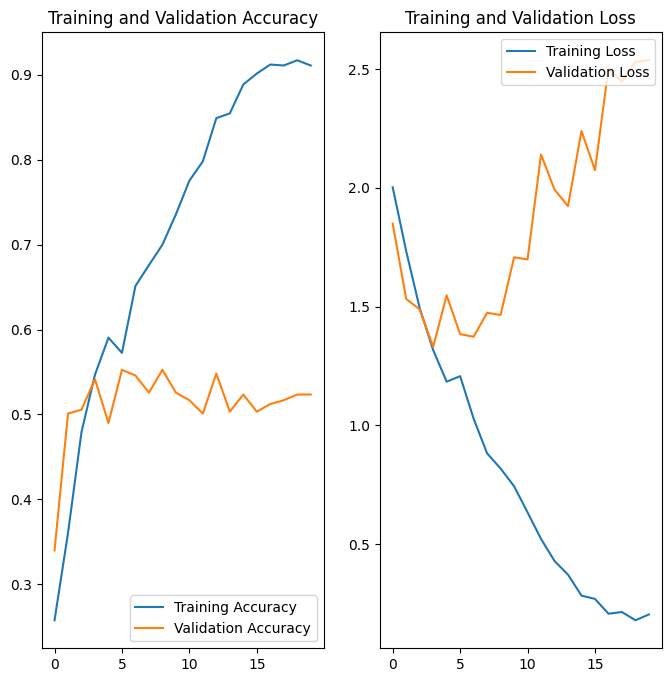

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

We can see that the model is having high accuracy in training data but the testing accuracy is much lower which indicates that there is model overfitting.

### Write your findings here

In [16]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
#adding random horizontal flip, rotation, zoom
augmentation_data = keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

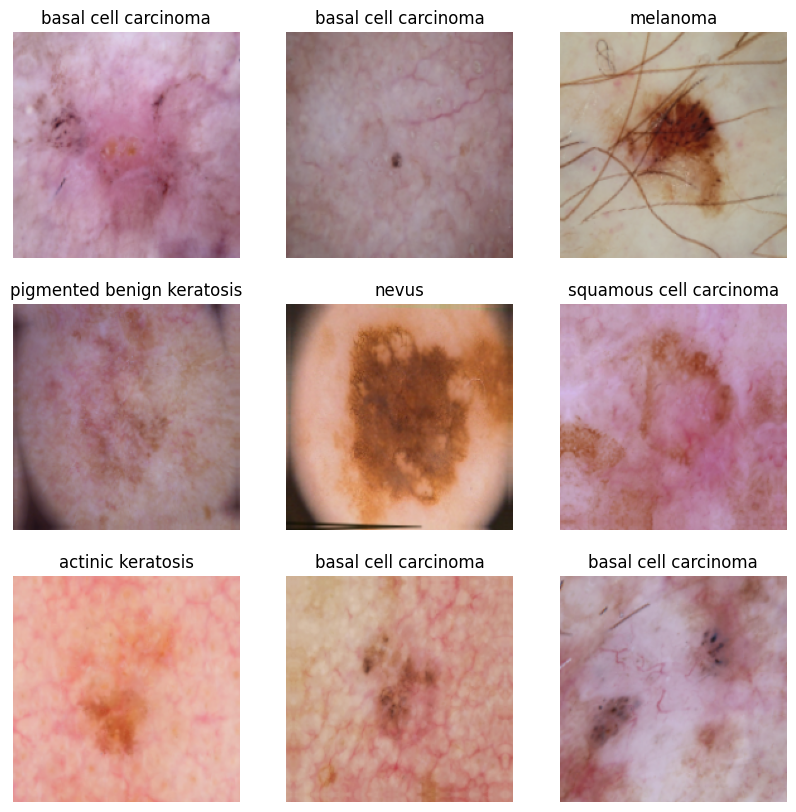

In [17]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_images = augmentation_data(images)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [18]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model = Sequential([
  augmentation_data,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(9, activation='softmax')
])

### Compiling the model

In [19]:
## Your code goes here
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [20]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.1703 - loss: 2.4258 - val_accuracy: 0.2640 - val_loss: 1.9445
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.3284 - loss: 1.8936 - val_accuracy: 0.3400 - val_loss: 1.7716
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.3939 - loss: 1.6983 - val_accuracy: 0.4407 - val_loss: 1.6088
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.4349 - loss: 1.5556 - val_accuracy: 0.4452 - val_loss: 1.5946
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.4345 - loss: 1.5491 - val_accuracy: 0.5056 - val_loss: 1.4696
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.4775 - loss: 1.4974 - val_accuracy: 0.4944 - val_loss: 1.5040
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.4950 - loss: 1.4227 - val_accuracy: 0.4989 - val_loss: 1.4098
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5289 - loss: 1.3691 - val_accuracy: 0.5302 - v

### Visualizing the results

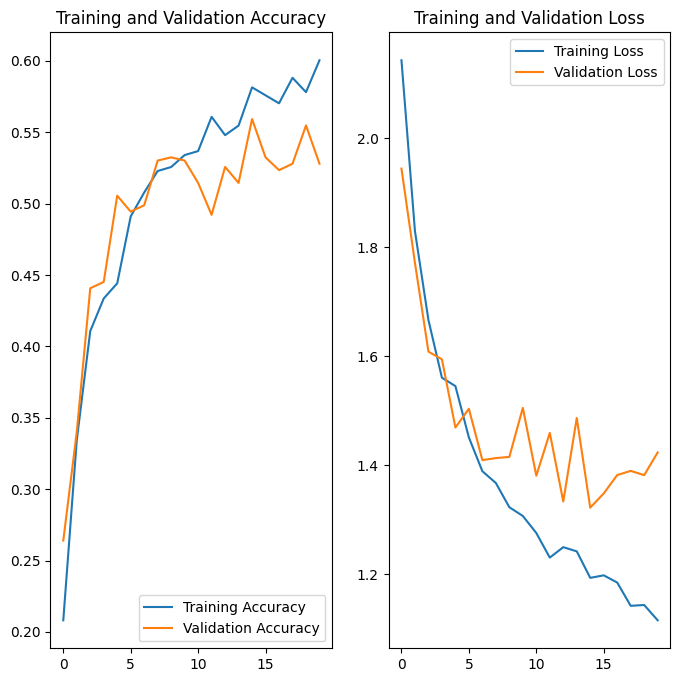

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

From the graph, we can see that
1. The problem of overfitting has been solved as the accuracy on train and test sets are similar.
2. The model is underfitting on both sets as the model fails to obtain high accuracy.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [22]:
## Your code goes here.
class_names = os.listdir(data_dir_train)
data_list = []
for class_name in class_names:
    class_dir = os.path.join(data_dir_train, class_name)
    for filename in os.listdir(class_dir):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(class_dir, filename)
            data_list.append((image_path, class_name))

In [23]:
df = pd.DataFrame(data_list)
df.columns = ['Path', 'Label']
df

,Path,Label
0,Train/actinic keratosis/ISIC_0025803.jpg,actinic keratosis
1,Train/actinic keratosis/ISIC_0027950.jpg,actinic keratosis
2,Train/actinic keratosis/ISIC_0026905.jpg,actinic keratosis
3,Train/actinic keratosis/ISIC_0028854.jpg,actinic keratosis
4,Train/actinic keratosis/ISIC_0026848.jpg,actinic keratosis
...,...,...
2234,Train/nevus/ISIC_0029309.jpg,nevus
2235,Train/nevus/ISIC_0029460.jpg,nevus
2236,Train/nevus/ISIC_0029133.jpg,nevus
2237,Train/nevus/ISIC_0029025.jpg,nevus


In [24]:
viz_df = df['Label'].value_counts().sort_values(ascending=False)


In [25]:
viz_df = pd.DataFrame(viz_df)
viz_df.reset_index(inplace=True)
viz_df.columns = ['Condition', 'Count']
viz_df

,Condition,Count
0,pigmented benign keratosis,462
1,melanoma,438
2,basal cell carcinoma,376
3,nevus,357
4,squamous cell carcinoma,181
5,vascular lesion,139
6,actinic keratosis,114
7,dermatofibroma,95
8,seborrheic keratosis,77


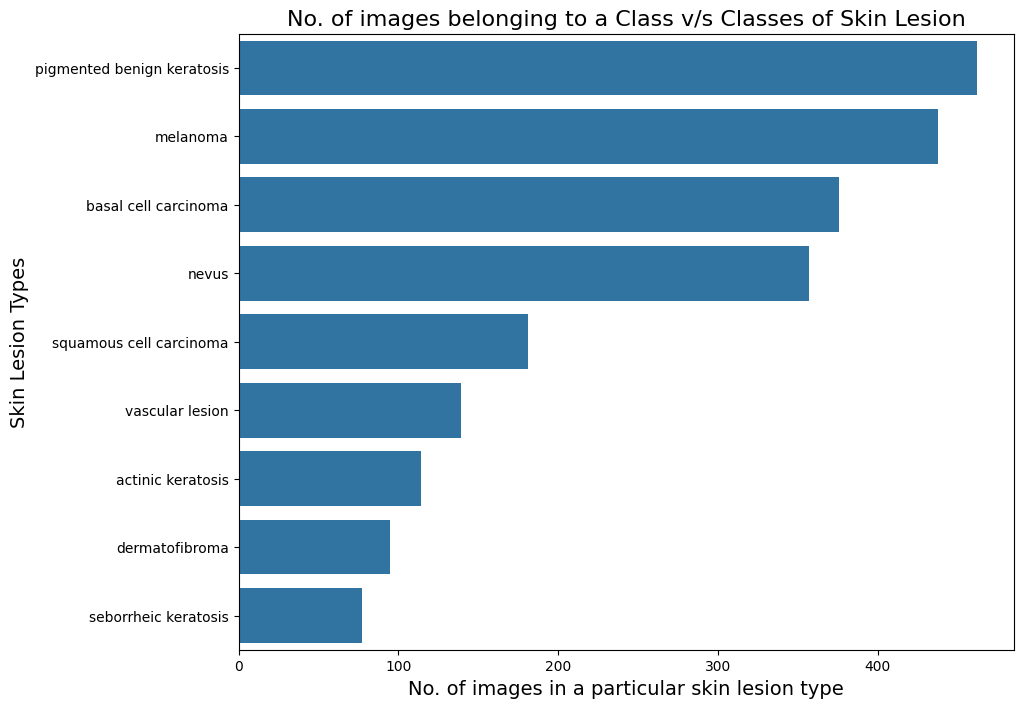

In [26]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.barplot(x="Count", y="Condition", data=viz_df)
plt.title('No. of images belonging to a Class v/s Classes of Skin Lesion', fontsize=16)
plt.xlabel('No. of images in a particular skin lesion type', fontsize=14)
plt.ylabel('Skin Lesion Types', fontsize=14)
plt.show()

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


seborrheic keratosis has the least number of samples at 77, whereas pigmented benign keratosis and melanoma has the most number of samples at 462 and 438 respectively.

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [27]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [28]:
path_to_training_dataset=str(data_dir_train) + '/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x78F4F02059D0>: 100%|██████████| 500/500 [00:27<00:00, 18.51 Samples/s]


Initialised with 139 image(s) found.
Output directory set to Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78F4F5F1ED90>: 100%|██████████| 500/500 [00:24<00:00, 20.44 Samples/s]


Initialised with 462 image(s) found.
Output directory set to Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78F4F03C2FD0>: 100%|██████████| 500/500 [00:18<00:00, 27.05 Samples/s]


Initialised with 77 image(s) found.
Output directory set to Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x78F5081C3F50>: 100%|██████████| 500/500 [00:35<00:00, 14.02 Samples/s]


Initialised with 95 image(s) found.
Output directory set to Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78F4F0425D50>: 100%|██████████| 500/500 [00:18<00:00, 26.55 Samples/s]


Initialised with 438 image(s) found.
Output directory set to Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3872x2592 at 0x78F5C0B82C10>: 100%|██████████| 500/500 [01:24<00:00,  5.94 Samples/s]


Initialised with 181 image(s) found.
Output directory set to Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78F4F03EDD90>: 100%|██████████| 500/500 [00:16<00:00, 29.83 Samples/s]


Initialised with 376 image(s) found.
Output directory set to Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78F4F04EA010>: 100%|██████████| 500/500 [00:17<00:00, 28.11 Samples/s]


Initialised with 357 image(s) found.
Output directory set to Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x78F4F0553390>: 100%|██████████| 500/500 [01:14<00:00,  6.68 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [29]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [30]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list[:5]

['Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026468.jpg_b78ec020-cbae-41fb-99ee-141a585830e5.jpg',
 'Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029830.jpg_c35898eb-7a96-46f4-aabc-c8dfa1245259.jpg',
 'Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027452.jpg_b44e09ae-c386-4daf-b19b-32a48a35eeeb.jpg',
 'Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031993.jpg_510367f4-6c13-4abf-8ed3-d7934c51bf00.jpg',
 'Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028063.jpg_160543e8-3481-4811-a7b7-ecb76fda59b1.jpg']

In [31]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:5]

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis']

In [32]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [33]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([df, df2], ignore_index=True)

In [34]:
new_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,962
melanoma,938
basal cell carcinoma,876
nevus,857
squamous cell carcinoma,681
vascular lesion,639
actinic keratosis,614
dermatofibroma,595
seborrheic keratosis,577


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [35]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [36]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [37]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [38]:
## your code goes here
model = Sequential([
  augmentation_data,
  layers.Rescaling(1./255),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(9, activation='softmax')
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [39]:
## your code goes here
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    verbose=1,
    restore_best_weights=True
)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [40]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping]
)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 277ms/step - accuracy: 0.2259 - loss: 2.0304 - val_accuracy: 0.3682 - val_loss: 1.6542
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 74s 232ms/step - accuracy: 0.4009 - loss: 1.5533 - val_accuracy: 0.4469 - val_loss: 1.4598
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 241ms/step - accuracy: 0.4554 - loss: 1.4325 - val_accuracy: 0.4885 - val_loss: 1.4113
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 37s 218ms/step - accuracy: 0.5007 - loss: 1.3358 - val_accuracy: 0.5130 - val_loss: 1.2961
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 45s 245ms/step - accuracy: 0.5198 - loss: 1.2734 - val_accuracy: 0.4796 - val_loss: 1.3810
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 79s 230ms/step - accuracy: 0.5381 - loss: 1.2430 - val_accuracy: 0.5650 - val_loss: 1.1596
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 229ms/step - accuracy: 0.5586 - loss: 1.1627 - val_accuracy: 0.5739 - val_loss: 1.1444
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 39s 219ms/step - accuracy: 0.5666 - loss: 1

#### **Todo:**  Visualize the model results

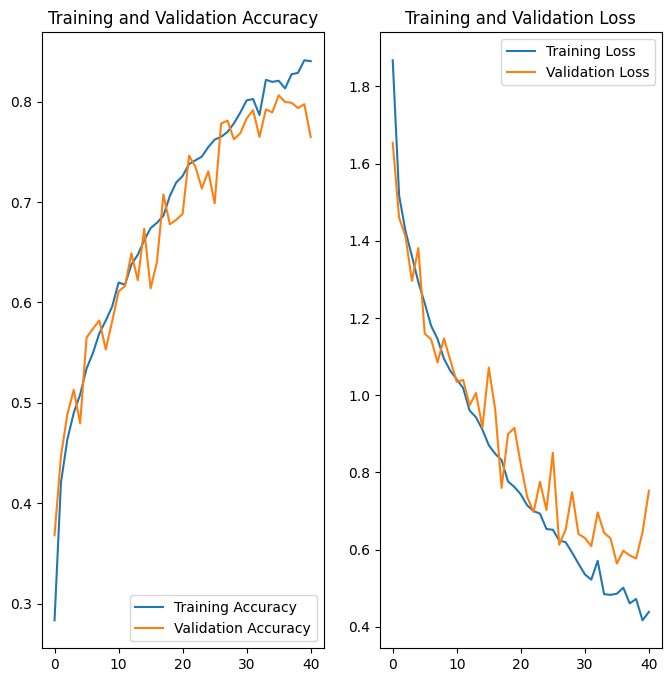

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(early_stopping.stopped_epoch+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



From the plot, we can see
1.   Model does not show overfitting or underfitting.
2.   Class rebalancining helped in predicting the different classes better.
3.   Achieved a high validation accuracy of 80.6% at 36 epochs.